<p style="font-size:32px; font-weight: bolder; text-align: center">PIMD simulations of indistinguishable particles <br/> using i-PI</p>
<br />

The goal of this tutorial is to perform and analyze PIMD simulations of indistinguishable particles in i-PI. We will also perform simulations of distinguishable particles for comparison and calculate the expectation values of the kinetic and potential energy operators for 4 types of systems: bosonic particles, distingushable particles, a mixture of bosonic and distinguishable particles, and fermionic particles.

## Prerequisites

You will need a working i-PI installation to run the simulations. Make sure to install from the correct branch by running the following commands:

```
git clone -b piqm2023 https://github.com/i-pi/i-pi
```

Refer to the following [quick guide](https://github.com/i-pi/i-pi/blob/master/README.md) on how to install i-Pi.

Apart from that, the code used for analysis of the simulation data requires certain optional Python packages. In case you encounter "missing package" errors when executing these scripts, install the packages using the following command:

`pip install -U numpy matplotlib ase chemiscope`

<span style="color:red">Do we really need all these packages? Remove the unnecessary ones after you finish writing this notebook.</span>

To start off, we will simulate three distinguishable particles in a 3D harmonic trap with $\hbar\omega_0 = 3 \, \mathrm{meV}$. The corresponding spring constant is $1.21647924 \cdot 10^{-8} \, \mathrm{Hartree / Bohr^2}$.

## Distinguishbale particles

### General input

The following is a basic example of an input file for a PIMD simulation of distinguishable particles in a canonical ensemble:

**input.xml**:
```xml
    <!--REGTEST
    COMMAND(4)    i-PI-driver -u -h localhost -m harm3d -o 1.21647924E-8
    ENDREGTEST-->
    <simulation threading='False' verbosity='low'>

    <ffsocket mode='unix' name='driver'>
            <address>localhost</address>
    </ffsocket>

    <total_steps> 10000 </total_steps>

    <output prefix="data">
      <trajectory stride="100" filename="pos" cell_units="angstrom">positions{angstrom}</trajectory>
      <!--<trajectory stride="1" filename="xc" format="xyz">x_centroid{angstrom}</trajectory>-->
      <properties stride="100"> [ step, time{femtosecond}, conserved, temperature{kelvin}, kinetic_cv,
            potential, virial_fq ] </properties>
    </output>

    <prng>
      <seed> 18885 </seed>
    </prng>

    <system>

      <forces>
          <force forcefield="driver"></force>
      </forces>

      <initialize nbeads="32">
        <positions mode="manual" bead="0"> [-55, -81, -49, -83, -93, -38, 5, 22, -99] </positions>
        <masses mode="manual"> ['1.0', '1.0', '1.0'] </masses>
        <labels mode="manual"> ['E', 'E', 'E'] </labels>
        <cell>
         [   2500, 0, 0, 0, 2500, 0, 0, 0, 2500 ]
        </cell>
        <velocities mode='thermal' units='kelvin'> 17.4 </velocities>
      </initialize>

      <normal_modes propagator='bab'>
              <nmts> 10 </nmts>
              <bosons> [] </bosons>
      </normal_modes>

      <ensemble>
         <temperature units="kelvin"> 17.4 </temperature>
      </ensemble>

      <motion mode="dynamics">
        <fixcom> False </fixcom>
        <dynamics mode="nvt">
         <timestep units="femtosecond"> 1 </timestep>
          <thermostat mode='pile_l'>
                <tau units='femtosecond'>100</tau>
          </thermostat>

        </dynamics>
      </motion>

    </system>

    </simulation>
```
**Note**: by default i-PI uses the atomic units (unless specified otherwise).

Let us look more closely at some of the parameters in this input file.

* The total number of MD time steps to be performed is defined in `<total_steps>..</total_steps>`. In our case, we choose 1000000 steps.
* The number of imaginary time slices (beads) is defined in `<initialize nbeads="..">`. In our case, we choose 32 beads.
* The temperature is defined in `<temperature units="kelvin">..</temperature>`. In our case we, choose a system temperature of 17.4 kelvin.
* The simulation cell geometry is defined inside `<cell> [x, 0, 0, 0, y, 0, 0, 0, z] </cell>` (where the zeros indicate an orthogonal basis) which accepts an array used to initialize the cell vector matrix.

The seed number, which is used to generate the initial state of the random number generator, is defined in `<prng><seed>..</seed></prng>`. It must be an integer, and it is used to randomly generate the initial velocities of the beads. Note that when `thermal` is set as the mode in `velocities`, it tells i-PI to generate velocities from a Maxwell-Boltzmann distribution according to the temperature provided in `<velocities>..</velocities>` (which in this case coincides with the system temperature).

The starting positions of the beads are defined inside the `<positions></positions>` tag, which is nested within the `<initialize nbeads="..">` tag. Pay special attention to its structure:

`<positions mode="manual" bead="0"> [x1, y1, z1, x2, y2, z2, ...] </positions>`

The initial coordinates are listed inside square brackets (this is a one-dimensional list, i.e., an array). The coordinates themselves consist of ordered triplets of numbers. Each triplet corresponds to the x, y and z components of the position vector. The total number of triplets must be equal to the total number of quantum particles that we wish to simulate.

By using the parameter `mode="manual"` you inform i-PI that the coordinates will be specified in the input file itself (as opposed to loading them from elsewhere). In addition, the `bead` parameter specifies the index of the bead for which we set the initial positions. Unless specified otherwise, the bead positions are initialized to zero.

The dynamics that correspond to the selected ensemble are specified inside the `<dynamics mode="nvt">..</dynamics>`. The timestep, as well as the properties of the thermostat (e.g., the timescale of the friction coefficient, `<tau units='femtosecond'>..</tau>`) are defined within this tag. Note that `mode='pile_l'` attaches a white noise Langevin thermostat to the normal mode representation.

The format of the output of the simulation is specified in the `<output prefix="data">..</output>` tag. In particular, the list of the desired physical observables is defined in the `<properties stride="100"> [ .. ] </properties>`. We chose to extract the following energy estimators:

* The virial kinetic energy estimator (`virial_fq`). *Note*: i-PI calculates `virial_fq` by taking the dot product of the forces and coordinates. Therefore, in order to obtain the correct energy, one must take the negative of the printed value.
* The potential energy estimator (`potential`).
* The centroid-virial kinetic energy estimator (`kinetic_cv`).

Also, in order to obtain particle coordinates, we write `<trajectory stride="100" filename="pos" cell_units="angstrom">..</trajectory>`. In both cases, `stride="100"` means that the output is printed once in every 100 steps.

### Adding the external harmonic trap

As a reminder, i-PI does not perform force calculations itself. Instead, it relies on an external engine for this task. Once an external engine is properly configured, i-PI establishes communication with the engine through a socket connection to generate the required molecular dynamics trajectory.

Typically, i-PI comes with some basic Fortran hard-coded potentials that can be accessed through the `i-pi-driver` file. You should have this file if you properly compiled the code in the “drivers” directory (e.g., using the UNIX utility `make`). We will make use of this empirical potential client code to perform our PIMD simulations. In particular, we will use the `harm3D` potential which, as the name suggests, corresponds to the 3D harmonic potential. Most potentials require additional arguments (such as the spring constant, in the case of the harmonic oscillator). Some additional "built-in" potentials include the double well potential, Lennard-Jones potential, Morse potential, and Zundel potential. For a comprehensive list of all the potentials, please refer to the `drivers/f90/driver.f90` file.

### Running the simulation

To run this simulation, follow the next steps:

1. Open a terminal and make sure that i-PI commands are available using `source ~/i-pi/env.sh`.
2. Navigate to the directory that contains the input file.
3. Run the command `i-pi <input-file-name>.xml &` (in our case the file name is `input.xml`).

If everything is correct, you should see the following message:

```
 ____       ____       ____       ____
/    \     /    \     /    \     /    \
|  #################################  |
\__#_/     \____/     \____/     \_#__/
   #    _        _______  _____    #
   #   (_)      |_   __ \|_   _|   #      -*-     v 2.0    -*-
   #   __  ______ | |__) | | |     #
   Y  [  ||______||  ___/  | |     #      A Universal Force Engine
  0 0  | |       _| |_    _| |_    #
   #  [___]     |_____|  |_____|   #
 __#_       ____       ____       _#__
/  # \     /    \     /    \     / #  \
|  #################################  |
\____/     \____/     \____/     \____/


 # @simulation: Fetchingffsocket
 # Initializing system object
 # Initializing simulation object
 # Resampling velocities at temperature 17.4 kelvin
 # Binding the forces
 @ForceField: Starting the polling thread main loop.
 # i-PI loaded input file:  input.xml
```

4. Now, i-PI awaits for the driver. To run the driver, execute the following command:

```i-pi-driver -u -m harm3d -o 1.21647924E-8 -h localhost -v```

Notice a few things:

* The `-o` flag is used to pass the spring constant as an argument to the driver.
* The `-u` flag tells i-PI to use the unix socket.
* The `-h` flag specifies the hostname. Must coincide with the socket specified in the input file (in our case, this is `localhost`).

After running the command, the following messages will appear in the terminal:

```
@SOCKET:   Client asked for connection from . Now hand-shaking.
@SOCKET:   Handshaking was successful. Added to the client list.
# Average timings at MD step       0. t/step: 6.97272e-02
SOFTEXIT CALLED FROM THREAD <_MainThread(MainThread, started 140592094656320)>  @ SIMULATION: Exiting cleanly.
!W! Soft exit has been requested with message: ' @ SIMULATION: Exiting cleanly.
I-PI reports success. Restartable as is: NO.'. Cleaning up.
@SOCKET: Shutting down the driver interface.
SOFTEXIT: Saving the latest status at the end of the step
```

```
  DRIVER - Connecting to host localhost
  using an UNIX socket.
  Message from server: STATUS
  Message from server: STATUS
  Message from server: POSDATA
  Allocating buffer and data arrays, with            3  atoms
  Message from server: STATUS
  Message from server: GETFORCE
....
  Message from server: EXIT
  Unexpected header EXIT
STOP ENDED
```

<hr />

At the same time, the following files should appear in the same directory as the input file:

* `data.out` - contains the measured physical quantities (observables). The columns coincide with the requested quantities in the `<properties stride="100"> [ .. ] </properties>` tag of the input file.
* `data.pos_#.xyz` (where # corresponds to the bead index) - contains the Cartesian coordinates of all the particles in the # timeslice.
* `RESTART` - contains the necessary information to restart the simulation.

### Analysis

With the aforementioned output files, it is possible to calculate the mean total energy of the quantum system using the `analysis.py` script. This Python script is specifically designed to analyze i-PI data related to the 3D harmonic oscillator. To run the analysis script, use the following command:

```
python3 analyze_bosons_convergence.py path/to/results/bosons_converged_03_32_17.8_1/data.out
```

The final result for 3 distinguishable particles should be:

```
Avg energy (virial): 0.0006618614666246969
Avg energy (centroid-virial): ?
Analytical result: 0.00065142
```


## Indistinguishable particles - Bosons

Now, let us turn our attention to indistinguishable particles. Specifically, we aim to perform a path-integral molecular dynamics (PIMD) simulation involving three bosons, utilizing the same parameters as those employed in the previously discussed scenario with distinguishable particles. Fortunately, performing a bosonic simulation merely necessitates a minor adjustment to the existing input file. As you might have noticed, the input file for distinguishable particles contains the following code:

```xml
<normal_modes propagator='bab'>
      <nmts> 10 </nmts>
      <bosons> [] </bosons>
</normal_modes>
```

In the distinguishable case, it merely informs i-PI that the simulation should with a numerical Verlet type propagation ("bab scheme"). The purpose of the (currently empty) `<bosons>[..]</bosons>` tag, is to store an array containing the (zero-based) indices of the atoms designated as bosons.

Consequently, to perform a bosonic PIMD simulation, it is necessary to populate this array with the indices of the atoms that should be treated as bosons. In our specific case, we denote all three atoms present in the simulation as bosons by specifying the following:

```xml
<normal_modes propagator='bab'>
      <nmts> 10 </nmts>
      <bosons> [0, 1, 2] </bosons>
</normal_modes>
```

From this point onwards, the procedure remains largely unchanged. To execute the simulation, simply follow the same steps as before.

When running the analysis script, add the flag `-b` to mark that the simulation is bosonic:

```
python3 analyze_bosons_convergence.py path/to/results/three-bosons/data.out
```

The final result should be:

```
Avg energy (virial): 0.0005962287734208224
Avg energy (centroid-virial): ?
Analytical: 0.0005865352049064479
```

**Note**:

* The potential energy estimator is unaffected by particle exchange, and is therefore valid for all types of statistics (i.e., for both distinguishable and indistinguishable particles).
* The virial estimator can be used both for distinguishable and indistinguishable particles, as long as the system is **bound** (i.e., localized and non-periodic). All the systems discussed in this tutorial are trapped in a harmonic potential, which is why the virial estimator yielded correct results.
* The centroid-virial estimator is not suitable for indistinguishable particles due to exchange effects.

## Two bosons and one distinguishable particle

i-PI also supports PIMD simulations of mixed systems. For example, to simulate a three-particle system, with two particles being bosons, one should modify the previous input as follows:

```xml
<normal_modes propagator='bab'>
      <nmts> 10 </nmts>
      <bosons> [0, 1] </bosons>
</normal_modes>
```

Note the absence of `2` in the array of boson indices, indicating that only the first two atoms are bosons.
Also, because these are non-interacting particles, we can simply add the energies of the pair of bosons with the energy of the third particle. Running the simulation and performing the analysis yields:

```
Avg energy (virial): 0.0006338746994440945
Analytical: 0.00062348
```

## Three fermions

Recall that the expectation values in the case of fermions are evaluated by re-weighting the expectation values from the corresponding bosonic simulations. Hence, we can leverage the results obtained from simulating three bosons in a harmonic trap to infer the average energy for an analogous fermionic system. Practically speaking, our task involves calculating the *configuration weight*, which can be determined using the following recursive relation:

$$
W_{B/F}^{\left(N\right)}=\frac{1}{N}\sum_{k=1}^{N}\xi^{k-1}e^{-\beta E_{N}^{\left(k\right)}}W_{B/F}^{\left(N-k\right)},\quad W_{B/F}^{\left(0\right)}=1,
$$

where $\xi=1$ ($\xi=-1$) for bosons (fermions). The instantaneous spring energies, $E_{N}^{\left(k\right)}$, can be obtained from the `.xyz` trajectory files. Once $W_{B/F}^{\left(N\right)}$ is known, one can recover the fermionic expectation values from the bosonic simulations by re-weighting:

$$
\left\langle \hat{O}\right\rangle _{F}=\frac{\left\langle \varepsilon_{O}s\right\rangle _{B}}{\left\langle s\right\rangle _{B}},
$$

where $\varepsilon_{O}$ is the desired estimator (in our case, the virial total energy estimator) and $s = W_F^{N} / W_B^{N}$ is the signed relative weight for each sampled configuration.

**Important note**: The fermion sign problem poses a significant challenge, making convergence increasingly difficult as the inverse temperature and/or system size are increased. To mitigate this issue, we perform the fermionic simulation at a moderate temperature.

These formulas are already implemented in `analysis.py`, so to obtain the mean energy of the fermionic system, simply run:

```
python3 analyze_bosons_convergence.py path/to/results/three-fermions/data.out (ADDITIONAL FLAGS FOR FERMIONS)
```

The final result should be:

```
Avg energy (virial): ?
Analytical: ?
```

## Energy estimators

In this tutorial, we computed the average kinetic energy and potential energy for both distinguishable and indistinguishable particles, using various estimators. Let us briefly discuss the different types of energy estimators that exist.

The mean **potential energy** was calculated using the *potential energy estimator*, which is given by

$$
\left\langle V\right\rangle =\frac{1}{P}\sum_{j=1}^{P}U\left(\mathbf{r}_{j}^{\left(1\right)},\dots,\mathbf{r}_{j}^{\left(N\right)}\right),
$$

where $N$ is the number of particles in the quantum system, $P$ is the number of beads, $\mathbf{r}_{j}^{\left(i\right)}$ is the position vector of the $j$th bead of the $i$th quantum particle, $U$ is the potential (e.g., external potential, interaction potential, or both).



The mean **kinetic energy** was calculated using the *virial estimator*, which is given by

$$
\left\langle K\right\rangle =\left\langle \frac{1}{2P}\sum_{i=1}^{N}\sum_{j=1}^{P}\frac{\partial U}{\partial\mathbf{r}_{j}^{\left(i\right)}}\cdot\mathbf{r}_{j}^{\left(i\right)}\right\rangle
$$


In addition, the kinetic energy can also be calculated using the so-called *centroid-virial estimator*:

$$
\left\langle K\right\rangle =\frac{dN}{2\beta}+\left\langle \frac{1}{2P}\sum_{i=1}^{N}\sum_{j=1}^{P}\frac{\partial U}{\partial\mathbf{r}_{j}^{\left(i\right)}}\cdot\left(\mathbf{r}_{j}^{\left(i\right)}-\tilde{\mathbf{r}}^{\left(i\right)}\right)\right\rangle
$$

where $d$ is the dimension of the system (in our case, $d=3$) and $\tilde{\mathbf{r}}^{\left(i\right)}$ is the centroid of the $i$th ring-polymer, which is defined by

$$
\tilde{\mathbf{r}}^{\left(i\right)}=\frac{1}{P}\sum_{j=1}^{P}\mathbf{r}_{j}^{\left(i\right)}.
$$

A key advantage of this estimator is its applicability to periodic systems, in contrast to the virial estimator. However, it is not suitable for indistinguishable particles due to exchange effects. Nevertheless, our recent findings demonstrate that it is possible to modify the centroid-virial estimator such that it would be valid for indistinguishable particles. More on that during the poster session.

Lastly, it is worth noting that the kinetic energy can also be evaluated using the primitive (thermodynamic) estimator. In the distinguishable case, it is given by

$$
\left\langle K\right\rangle =\frac{dNP}{2\beta}-\sum_{k=1}^{P}\sum_{i=1}^{N}\frac{1}{2}m_{i}\omega_{P}^{2}\left(\mathbf{r}_{k}^{\left(i\right)}-\mathbf{r}_{k+1}^{\left(i\right)}\right)^{2},
$$
where $\omega_{P}=\sqrt{P}/\beta\hbar$. For indistinguishable particles, the primitive estimator has the form

$$
\left\langle K\right\rangle =\frac{dNP}{2\beta}+\left\langle V_{B}^{\left(N\right)}+\beta\frac{\partial V_{B}^{\left(N\right)}}{\partial\beta}\right\rangle,
$$

where

$$
\begin{cases}
V_{B}^{\left(N\right)}+\beta\frac{\partial V_{B}^{\left(N\right)}}{\partial\beta}=\frac{\sum_{k=1}^{N}\left[V_{B}^{\left(N-k\right)}+\beta\frac{\partial V_{B}^{\left(N-k\right)}}{\partial\beta}-E_{N}^{\left(k\right)}\right]e^{-\beta\left(E_{N}^{\left(k\right)}+V_{B}^{\left(N-k\right)}\right)}}{\sum_{k=1}^{N}e^{-\beta\left(E_{N}^{\left(k\right)}+V_{B}^{\left(N-k\right)}\right)}}\\
V_{B}^{\left(0\right)}+\beta\frac{\partial V_{B}^{\left(0\right)}}{\partial\beta}=0
\end{cases}
$$

In practice, the primitive estimator is rarely used due to the fact that its variance grows with the number of beads. In contrast, the variance of the virial estimators is insensitive to $P$.

## Assignment

To gain a deeper understanding of PIMD simulations in i-PI, we encourage you to complete the following assignment:

> Plot the mean total energy as a function of $\beta \hbar \omega_0$, where $\omega_0$ is the frequency of the harmonic potential, for three types of systems:
> 1) Three distinguishable particles.
> 2) Three bosons.

Plot the data for the discrete set of temperatures $\beta\hbar\omega_0=1,2,3,4,5$. If the calculations are performed accurately, the resulting graphs should resemble the following:

**<PLOT 1> <PLOT 2> <PLOT 3>**

In addition, you can perform the same simulations for three fermions. We advise to pick slightly higher temperatures for better convergence due to the sign problem discussed above. For example, you can choose temperatures in the interval $\beta \hbar \omega_0 = 0.75 - 2$. Try plotting the sign average as a function of $\beta \hbar \omega_0$. You will observe that as the sign average decreases the variance of the fermionic measurements grows.

Text(0, 0.5, 'temperature / K')

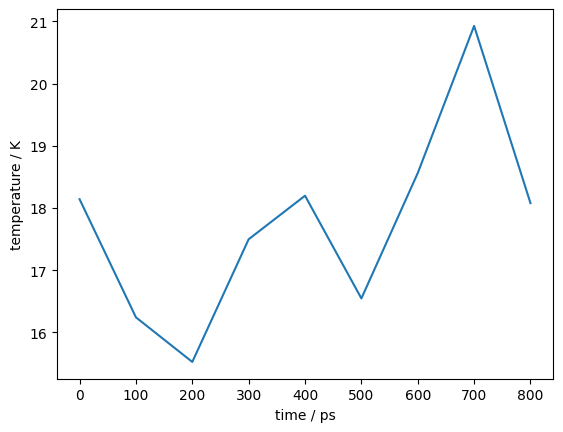

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ase, ase.io
import chemiscope
import pimdmooc
pimdmooc.add_ipi_paths()


simulation_data = pimdmooc.read_ipi_output("results/3p_3D_HO_bhw_2/data.out")
plt.plot(simulation_data["time"], simulation_data["temperature"])
plt.xlabel("time / ps"); plt.ylabel("temperature / K")
